## Assignment: Using LSTMs to Classify the 20 Newsgroups Data Set
The 20 Newsgroups data set is a well known classification problem. The goal is to classify which newsgroup a particular post came from.  The 20 possible groups are:

`comp.graphics
comp.os.ms-windows.misc
comp.sys.ibm.pc.hardware
comp.sys.mac.hardware
comp.windows.x	rec.autos
rec.motorcycles
rec.sport.baseball
rec.sport.hockey	
sci.crypt
sci.electronics
sci.med
sci.space
misc.forsale	
talk.politics.misc
talk.politics.guns
talk.politics.mideast	
talk.religion.misc
alt.atheism
soc.religion.christian`

As you can see, some pairs of groups may be quite similar while others are very different.

The data is given as a designated training set of size 11314 and test set of size 7532.  The 20 categories are represented in roughly equal proportions, so the baseline accuracy is around 5%.

To begin, review the code below.  This will walk you through the basics of loading in the 20 newsgroups data, loading in the GloVe data, building the word embedding matrix, and building the LSTM model.

In [28]:
import numpy as np

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,SimpleRNN

import keras
import tensorflow as tf
from sklearn.datasets import fetch_20newsgroups

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

In [3]:
max_features = 20000
seq_length = 30  # How long to make our word sequences
batch_size = 32


In [4]:
# Download the 20 newsgroups data - there is already a designated "train" and "test" set
newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')



In [5]:
len(newsgroups_train.data), len(newsgroups_test.data)

(11314, 7532)

In [6]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(newsgroups_train.data)

In [7]:
sequences_train = tokenizer.texts_to_sequences(newsgroups_train.data)
sequences_test = tokenizer.texts_to_sequences(newsgroups_test.data)

In [8]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))


Found 134142 unique tokens.


In [9]:
x_train = pad_sequences(sequences_train, maxlen=seq_length)
x_test = pad_sequences(sequences_test, maxlen=seq_length)


In [10]:
x_train.shape
#x_train

(11314, 30)

In [11]:
y_train = keras.utils.np_utils.to_categorical(np.asarray(newsgroups_train.target))
y_test = keras.utils.np_utils.to_categorical(np.asarray(newsgroups_test.target))


You will be using the Glove pre-trained word vectors.  Download Glove word vectors using this link:
(NOTE: this will start downloading an 822MB file)

https://nlp.stanford.edu/data/glove.6B.zip

Then unzip the file and fill your local path to the file in the code cell below.

We will use the file `glove.6B.100d.txt`

In [12]:
embeddings_index = {}
f = open('glove.6B.100d.txt',  encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()




Let's just look at a word embedding

In [13]:
dog_vec = embeddings_index['dog']
dog_vec

array([ 0.30817  ,  0.30938  ,  0.52803  , -0.92543  , -0.73671  ,
        0.63475  ,  0.44197  ,  0.10262  , -0.09142  , -0.56607  ,
       -0.5327   ,  0.2013   ,  0.7704   , -0.13983  ,  0.13727  ,
        1.1128   ,  0.89301  , -0.17869  , -0.0019722,  0.57289  ,
        0.59479  ,  0.50428  , -0.28991  , -1.3491   ,  0.42756  ,
        1.2748   , -1.1613   , -0.41084  ,  0.042804 ,  0.54866  ,
        0.18897  ,  0.3759   ,  0.58035  ,  0.66975  ,  0.81156  ,
        0.93864  , -0.51005  , -0.070079 ,  0.82819  , -0.35346  ,
        0.21086  , -0.24412  , -0.16554  , -0.78358  , -0.48482  ,
        0.38968  , -0.86356  , -0.016391 ,  0.31984  , -0.49246  ,
       -0.069363 ,  0.018869 , -0.098286 ,  1.3126   , -0.12116  ,
       -1.2399   , -0.091429 ,  0.35294  ,  0.64645  ,  0.089642 ,
        0.70294  ,  1.1244   ,  0.38639  ,  0.52084  ,  0.98787  ,
        0.79952  , -0.34625  ,  0.14095  ,  0.80167  ,  0.20987  ,
       -0.86007  , -0.15308  ,  0.074523 ,  0.40816  ,  0.0192

In [14]:
## This creates a matrix where the $i$th row gives the word embedding for the word represented by integer $i$.
## Essentially, these will be the "weights" for the Embedding Layer
## Rather than learning the weights, we will use these ones and "freeze" the layer

embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i,:len(embedding_vector)] = embedding_vector

In [15]:
print(embedding_matrix)

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.038194   -0.24487001  0.72812003 ... -0.1459      0.82779998
   0.27061999]
 [-0.18970001  0.050024    0.19084001 ... -0.39804     0.47646999
  -0.15983   ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.13573     0.32887     0.064063   ... -0.60479999  0.17851999
   0.49908   ]]


In [16]:
embedding_matrix.shape

(134143, 100)

## Assignment
### PART-1
Train the following LSTM model with the following hyper-parameters:

1. Adam optimizer with learning rate =0.001
2. Categorical cross-entropy loss for training
3. Train for 50 epochs

Evaluate the performance of your model based on the total prediction accuracy.  

## LSTM Layer
`keras.layers.recurrent.LSTM(units, activation='tanh', recurrent_activation='hard_sigmoid', use_bias=True, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, dropout=0.0, recurrent_dropout=0.0)`

- Similar in structure to the `SimpleRNN` layer
- `units` defines the dimension of the recurrent state
- `recurrent_...` refers the recurrent state aspects of the LSTM
- `kernel_...` refers to the transformations done on the input



In [20]:
word_dimension = 100  # This is the dimension of the words we are using from GloVe
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                            word_dimension,  
                            weights=[embedding_matrix],  # We set the weights to be the word vectors from GloVe
                            input_length=seq_length,
                            trainable=False))  # By setting trainable to False, we "freeze" the word embeddings.
model.add(LSTM(30, dropout=0.25, recurrent_dropout=0.25))
model.add(Dense(20, activation='softmax'))

model.summary()
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 30, 100)           13414300  
                                                                 
 lstm (LSTM)                 (None, 30)                15720     
                                                                 
 dense_1 (Dense)             (None, 20)                620       
                                                                 
Total params: 13,430,640
Trainable params: 16,340
Non-trainable params: 13,414,300
_________________________________________________________________


In [48]:

model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

  
history=model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=50,
              verbose=1,
              validation_data=(x_test, y_test))



Epoch 1/50
354/354 [==============================] - 6s 12ms/step - loss: 2.5882 - accuracy: 0.1899 - val_loss: 2.3389 - val_accuracy: 0.2606
Epoch 2/50
354/354 [==============================] - 4s 12ms/step - loss: 2.2084 - accuracy: 0.3144 - val_loss: 2.1476 - val_accuracy: 0.3380
Epoch 3/50
354/354 [==============================] - 4s 12ms/step - loss: 2.0443 - accuracy: 0.3634 - val_loss: 2.0245 - val_accuracy: 0.3741
Epoch 4/50
354/354 [==============================] - 4s 13ms/step - loss: 1.9457 - accuracy: 0.3999 - val_loss: 1.9498 - val_accuracy: 0.3975
Epoch 5/50
354/354 [==============================] - 5s 13ms/step - loss: 1.8683 - accuracy: 0.4237 - val_loss: 1.9076 - val_accuracy: 0.4095
Epoch 6/50
354/354 [==============================] - 5s 13ms/step - loss: 1.8156 - accuracy: 0.4424 - val_loss: 1.8875 - val_accuracy: 0.4209
Epoch 7/50
354/354 [==============================] - 5s 13ms/step - loss: 1.7635 - accuracy: 0.4571 - val_loss: 1.8676 - val_accuracy: 0.4279

In [49]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 1.7630321979522705
Test accuracy: 0.48592671751976013


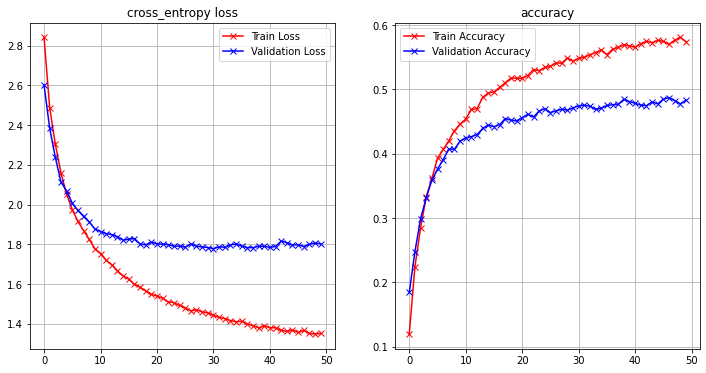

In [19]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history["loss"],'r-x', label="Train Loss")
ax.plot(history.history["val_loss"],'b-x', label="Validation Loss")
ax.legend()
ax.set_title('cross_entropy loss')
ax.grid(True)


ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history["accuracy"],'r-x', label="Train Accuracy")
ax.plot(history.history["val_accuracy"],'b-x', label="Validation Accuracy")
ax.legend()
ax.set_title('accuracy')
ax.grid(True)

### PART-2

1. Build a neural network with a SimpleRNN instead of an LSTM (with other dimensions and parameters the same). How does the performance compare?

2. Use the LSTM above without the pretrained word vectors (randomly initialize the weights and have them be learned during the training process).  How does the performance compare?

3. Try different sequence lengths, and dimensions for the hidden state of the LSTM.  Can you improve the model?


In [22]:

word_dimension = 100 
model_simpleRNN = Sequential()
model_simpleRNN.add(Embedding(len(word_index) + 1,
                            word_dimension,  
                            weights=[embedding_matrix],  # We set the weights to be the word vectors from GloVe
                            input_length=seq_length,
                            trainable=False))  # By setting trainable to False, we "freeze" the word embeddings.
model_simpleRNN.add(SimpleRNN(30, dropout=0.25, recurrent_dropout=0.25, activation="relu"))
model_simpleRNN.add(Dense(20, activation='softmax'))

model_simpleRNN.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 30, 100)           13414300  
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 30)                3930      
                                                                 
 dense_2 (Dense)             (None, 20)                620       
                                                                 
Total params: 13,418,850
Trainable params: 4,550
Non-trainable params: 13,414,300
_________________________________________________________________


In [25]:

model_simpleRNN.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

  
history=model_simpleRNN.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=50,
              verbose=1,
              validation_data=(x_test, y_test))

Epoch 1/50
354/354 [==============================] - 2s 4ms/step - loss: 2.3774 - accuracy: 0.2695 - val_loss: 2.3924 - val_accuracy: 0.2556
Epoch 2/50
354/354 [==============================] - 1s 4ms/step - loss: 2.3708 - accuracy: 0.2785 - val_loss: 2.3783 - val_accuracy: 0.2685
Epoch 3/50
354/354 [==============================] - 1s 4ms/step - loss: 2.3756 - accuracy: 0.2749 - val_loss: 2.3955 - val_accuracy: 0.2594
Epoch 4/50
354/354 [==============================] - 1s 4ms/step - loss: 2.3899 - accuracy: 0.2708 - val_loss: 2.4132 - val_accuracy: 0.2548
Epoch 5/50
354/354 [==============================] - 1s 4ms/step - loss: 2.3670 - accuracy: 0.2799 - val_loss: 2.4030 - val_accuracy: 0.2627
Epoch 6/50
354/354 [==============================] - 1s 4ms/step - loss: 2.3787 - accuracy: 0.2724 - val_loss: 2.3874 - val_accuracy: 0.2554
Epoch 7/50
354/354 [==============================] - 1s 4ms/step - loss: 2.3741 - accuracy: 0.2751 - val_loss: 2.4857 - val_accuracy: 0.2384
Epoch 

In [50]:
score = model_simpleRNN.evaluate(x_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 2.4197025299072266
Test accuracy: 0.25464683771133423


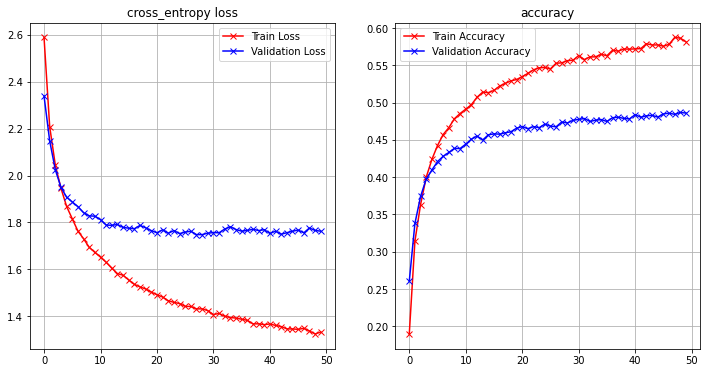

In [52]:

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history["loss"],'r-x', label="Train Loss")
ax.plot(history.history["val_loss"],'b-x', label="Validation Loss")
ax.legend()
ax.set_title('cross_entropy loss')
ax.grid(True)


ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history["accuracy"],'r-x', label="Train Accuracy")
ax.plot(history.history["val_accuracy"],'b-x', label="Validation Accuracy")
ax.legend()
ax.set_title('accuracy')
ax.grid(True)

Part 2 Question 2 Random weights

In [33]:
random_initializer = keras.initializers.RandomNormal(mean=0., stddev=1.)  # normal function initialization
dimension_shape = random_initializer(shape=(134143, 200))  

model_without_pretrained = Sequential()
model_without_pretrained.add(Embedding(len(word_index) + 1,
                            word_dimension, 
                            weights=[values],
                            input_length=seq_length,
                            trainable=False))  # By setting trainable to False, we "freeze" the word embeddings.
model_without_pretrained.add(LSTM(30, dropout=0.25, recurrent_dropout=0.25))
model_without_pretrained.add(Dense(20, activation='softmax'))

model_without_pretrained.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 30, 100)           13414300  
                                                                 
 lstm_2 (LSTM)               (None, 30)                15720     
                                                                 
 dense_4 (Dense)             (None, 20)                620       
                                                                 
Total params: 13,430,640
Trainable params: 16,340
Non-trainable params: 13,414,300
_________________________________________________________________


In [34]:
model_without_pretrained.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

  
history=model_without_pretrained.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=50,
              verbose=1,
              validation_data=(x_test, y_test))

Epoch 1/50
354/354 [==============================] - 6s 12ms/step - loss: 2.8359 - accuracy: 0.1552 - val_loss: 2.7175 - val_accuracy: 0.1895
Epoch 2/50
354/354 [==============================] - 4s 11ms/step - loss: 2.5798 - accuracy: 0.2447 - val_loss: 2.6302 - val_accuracy: 0.2266
Epoch 3/50
354/354 [==============================] - 4s 12ms/step - loss: 2.4539 - accuracy: 0.2764 - val_loss: 2.5854 - val_accuracy: 0.2369
Epoch 4/50
354/354 [==============================] - 4s 12ms/step - loss: 2.3921 - accuracy: 0.2951 - val_loss: 2.5503 - val_accuracy: 0.2492
Epoch 5/50
354/354 [==============================] - 4s 12ms/step - loss: 2.3255 - accuracy: 0.3092 - val_loss: 2.5377 - val_accuracy: 0.2581
Epoch 6/50
354/354 [==============================] - 4s 12ms/step - loss: 2.2828 - accuracy: 0.3227 - val_loss: 2.5238 - val_accuracy: 0.2657
Epoch 7/50
354/354 [==============================] - 4s 13ms/step - loss: 2.2509 - accuracy: 0.3341 - val_loss: 2.5080 - val_accuracy: 0.2674

In [35]:
score = model_without_pretrained.evaluate(x_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 2.4479897022247314
Test accuracy: 0.3230217695236206


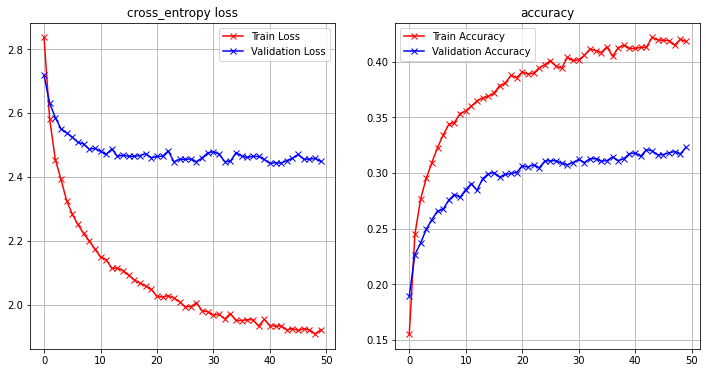

In [36]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history["loss"],'r-x', label="Train Loss")
ax.plot(history.history["val_loss"],'b-x', label="Validation Loss")
ax.legend()
ax.set_title('cross_entropy loss')
ax.grid(True)


ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history["accuracy"],'r-x', label="Train Accuracy")
ax.plot(history.history["val_accuracy"],'b-x', label="Validation Accuracy")
ax.legend()
ax.set_title('accuracy')
ax.grid(True)

PART 2 QUESTION 3

Seq_length= 50

In [74]:
word_dimension=100
seq_length=50

random_initializer = keras.initializers.RandomNormal(mean=0., stddev=1.)  # normal function initialization
dimension_shape = random_initializer(shape=(134143, 200))  

x_train = pad_sequences(sequences_train, maxlen=seq_length)
x_test = pad_sequences(sequences_test, maxlen=seq_length)



my_model = Sequential()
my_model.add(Embedding(len(word_index) + 1,
                            word_dimension,  
                            weights=[embedding_matrix], 
                            input_length=seq_length,
                            trainable=False))  # By setting trainable to False, we "freeze" the word embeddings.
my_model.add(LSTM(30,dropout=0.25, recurrent_dropout=0.25))
my_model.add(Dense(20, activation='softmax'))

my_model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_25 (Embedding)    (None, 50, 100)           13414300  
                                                                 
 lstm_18 (LSTM)              (None, 30)                15720     
                                                                 
 dense_21 (Dense)            (None, 20)                620       
                                                                 
Total params: 13,430,640
Trainable params: 16,340
Non-trainable params: 13,414,300
_________________________________________________________________


In [75]:
my_model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

  
history=my_model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=50,
              verbose=1,
              validation_data=(x_test, y_test))

Epoch 1/50
354/354 [==============================] - 9s 21ms/step - loss: 2.5421 - accuracy: 0.1909 - val_loss: 2.2273 - val_accuracy: 0.2723
Epoch 2/50
354/354 [==============================] - 7s 20ms/step - loss: 2.0708 - accuracy: 0.3376 - val_loss: 1.9460 - val_accuracy: 0.3656
Epoch 3/50
354/354 [==============================] - 8s 22ms/step - loss: 1.8421 - accuracy: 0.4095 - val_loss: 1.8013 - val_accuracy: 0.4172
Epoch 4/50
354/354 [==============================] - 8s 22ms/step - loss: 1.7022 - accuracy: 0.4526 - val_loss: 1.7285 - val_accuracy: 0.4440
Epoch 5/50
354/354 [==============================] - 8s 23ms/step - loss: 1.6178 - accuracy: 0.4756 - val_loss: 1.6728 - val_accuracy: 0.4608
Epoch 6/50
354/354 [==============================] - 8s 23ms/step - loss: 1.5509 - accuracy: 0.4971 - val_loss: 1.6166 - val_accuracy: 0.4793
Epoch 7/50
354/354 [==============================] - 8s 23ms/step - loss: 1.5032 - accuracy: 0.5094 - val_loss: 1.5893 - val_accuracy: 0.4877

In [76]:
score = my_model.evaluate(x_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 1.4164427518844604
Test accuracy: 0.5825809836387634


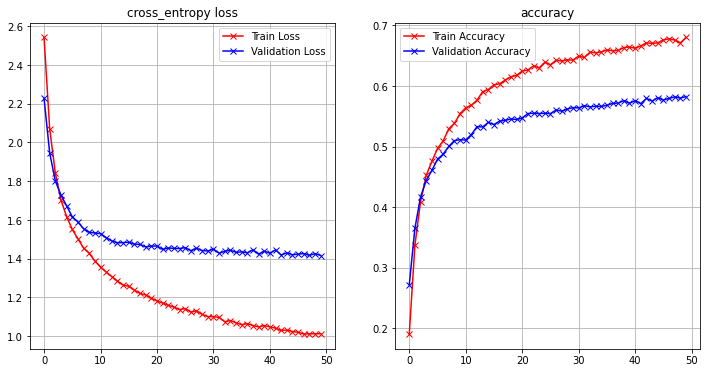

In [77]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history["loss"],'r-x', label="Train Loss")
ax.plot(history.history["val_loss"],'b-x', label="Validation Loss")
ax.legend()
ax.set_title('cross_entropy loss')
ax.grid(True)


ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history["accuracy"],'r-x', label="Train Accuracy")
ax.plot(history.history["val_accuracy"],'b-x', label="Validation Accuracy")
ax.legend()
ax.set_title('accuracy')
ax.grid(True)

Seq_length=100


In [78]:
seq_length=100
x_train = pad_sequences(sequences_train, maxlen=seq_length)
x_test = pad_sequences(sequences_test, maxlen=seq_length)



mymodel2 = Sequential()
mymodel2.add(Embedding(len(word_index) + 1,
                            word_dimension,  
                            weights=[embedding_matrix], 
                            input_length=seq_length,
                            trainable=False))  # By setting trainable to False, we "freeze" the word embeddings.
mymodel2.add(LSTM(30,dropout=0.25, recurrent_dropout=0.25))
mymodel2.add(Dense(20, activation='softmax'))

mymodel2.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_26 (Embedding)    (None, 100, 100)          13414300  
                                                                 
 lstm_19 (LSTM)              (None, 30)                15720     
                                                                 
 dense_22 (Dense)            (None, 20)                620       
                                                                 
Total params: 13,430,640
Trainable params: 16,340
Non-trainable params: 13,414,300
_________________________________________________________________


In [79]:
mymodel2.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

  
history=mymodel2.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=50,
              verbose=1,
              validation_data=(x_test, y_test))

Epoch 1/50
354/354 [==============================] - 16s 41ms/step - loss: 2.4507 - accuracy: 0.2144 - val_loss: 1.9620 - val_accuracy: 0.3440
Epoch 2/50
354/354 [==============================] - 14s 39ms/step - loss: 1.7558 - accuracy: 0.4197 - val_loss: 1.6232 - val_accuracy: 0.4615
Epoch 3/50
354/354 [==============================] - 15s 41ms/step - loss: 1.5270 - accuracy: 0.4932 - val_loss: 1.4882 - val_accuracy: 0.5015
Epoch 4/50
354/354 [==============================] - 15s 43ms/step - loss: 1.3938 - accuracy: 0.5339 - val_loss: 1.4101 - val_accuracy: 0.5313
Epoch 5/50
354/354 [==============================] - 15s 44ms/step - loss: 1.2946 - accuracy: 0.5676 - val_loss: 1.3614 - val_accuracy: 0.5477
Epoch 6/50
354/354 [==============================] - 16s 44ms/step - loss: 1.2317 - accuracy: 0.5896 - val_loss: 1.3177 - val_accuracy: 0.5621
Epoch 7/50
354/354 [==============================] - 16s 44ms/step - loss: 1.1849 - accuracy: 0.6029 - val_loss: 1.2890 - val_accuracy:

In [80]:
score = mymodel2.evaluate(x_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 1.1259946823120117
Test accuracy: 0.6731280088424683


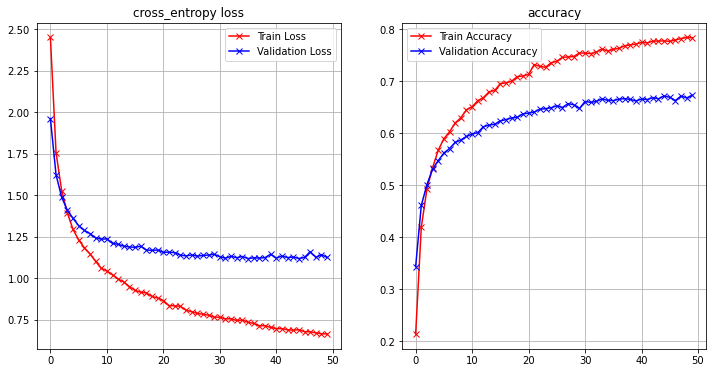

In [81]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history["loss"],'r-x', label="Train Loss")
ax.plot(history.history["val_loss"],'b-x', label="Validation Loss")
ax.legend()
ax.set_title('cross_entropy loss')
ax.grid(True)


ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history["accuracy"],'r-x', label="Train Accuracy")
ax.plot(history.history["val_accuracy"],'b-x', label="Validation Accuracy")
ax.legend()
ax.set_title('accuracy')
ax.grid(True)

In [43]:
embedding_matrix = np.zeros((len(word_index) + 1, 200))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i,:len(embedding_vector)] = embedding_vector

word_dimension=200
seq_length=30

x_train = pad_sequences(sequences_train, maxlen=seq_length)
x_test = pad_sequences(sequences_test, maxlen=seq_length)



mymodel3 = Sequential()
mymodel3.add(Embedding(len(word_index) + 1,
                            word_dimension,  
                            weights=[embedding_matrix], 
                            input_length=seq_length,
                            trainable=False))  # By setting trainable to False, we "freeze" the word embeddings.
mymodel3.add(LSTM(30,dropout=0.25, recurrent_dropout=0.25))
mymodel3.add(Dense(20, activation='softmax'))

mymodel3.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 30, 200)           26828600  
                                                                 
 lstm_7 (LSTM)               (None, 30)                27720     
                                                                 
 dense_9 (Dense)             (None, 20)                620       
                                                                 
Total params: 26,856,940
Trainable params: 28,340
Non-trainable params: 26,828,600
_________________________________________________________________


In [44]:
mymodel3.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

  
history=mymodel3.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=50,
              verbose=1,
              validation_data=(x_test, y_test))

Epoch 1/50
354/354 [==============================] - 6s 13ms/step - loss: 2.5639 - accuracy: 0.1933 - val_loss: 2.3074 - val_accuracy: 0.2658
Epoch 2/50
354/354 [==============================] - 5s 14ms/step - loss: 2.1875 - accuracy: 0.3144 - val_loss: 2.1230 - val_accuracy: 0.3480
Epoch 3/50
354/354 [==============================] - 5s 15ms/step - loss: 2.0310 - accuracy: 0.3630 - val_loss: 2.0090 - val_accuracy: 0.3715
Epoch 4/50
354/354 [==============================] - 5s 15ms/step - loss: 1.9413 - accuracy: 0.3961 - val_loss: 1.9498 - val_accuracy: 0.3946
Epoch 5/50
354/354 [==============================] - 5s 15ms/step - loss: 1.8665 - accuracy: 0.4193 - val_loss: 1.9104 - val_accuracy: 0.4079
Epoch 6/50
354/354 [==============================] - 6s 16ms/step - loss: 1.8114 - accuracy: 0.4369 - val_loss: 1.8830 - val_accuracy: 0.4178
Epoch 7/50
354/354 [==============================] - 6s 16ms/step - loss: 1.7854 - accuracy: 0.4466 - val_loss: 1.8806 - val_accuracy: 0.4205

In [45]:
score = mymodel3.evaluate(x_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 1.7763004302978516
Test accuracy: 0.48194369673728943


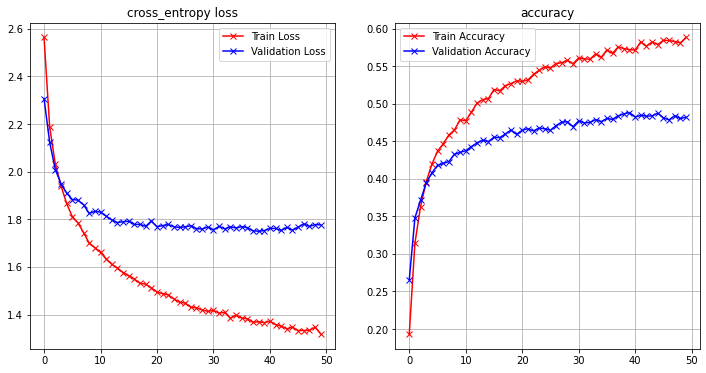

In [46]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history["loss"],'r-x', label="Train Loss")
ax.plot(history.history["val_loss"],'b-x', label="Validation Loss")
ax.legend()
ax.set_title('cross_entropy loss')
ax.grid(True)


ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history["accuracy"],'r-x', label="Train Accuracy")
ax.plot(history.history["val_accuracy"],'b-x', label="Validation Accuracy")
ax.legend()
ax.set_title('accuracy')
ax.grid(True)